In [2]:
import pandas as pd 

In [3]:
df = pd.read_csv('./dataset.csv')

species_counts = df["species"].value_counts()
print(species_counts.head(3))

species
Caenorhabditis elegans     1559
Drosophila melanogaster     926
Mus musculus                277
Name: count, dtype: int64


Let's isolate our dataset to only rows that with the Canorhabiditis elegans species, since it has the most data points 

In [4]:
df = df[df["species"] == "Caenorhabditis elegans"].reset_index(drop=True)
df.head(5) 

,id,compound_name,species,strain,dosage,age_at_initiation,treatment_duration,avg_lifespan_change_percent,avg_lifespan_significance,max_lifespan_change_percent,max_lifespan_significance,gender_new,weight_change_percent,weight_change_significance,ITP,pubmed_id,notes,last_modified
0,226,EUK-8,Caenorhabditis elegans,N2,0.05 mM,NaN,NaN,-12.90,S,NaN,NaN,Unknown,NaN,NaN,No,12521609,Lifespan assay conducted on solid medium. EUK-...,2024-10-07 15:17:17
1,223,EUK-8,Caenorhabditis elegans,N2,0.5 mM,NaN,NaN,-33.10,S,NaN,NaN,Unknown,NaN,NaN,No,12521609,Lifespan assay conducted on solid medium. EUK-...,2024-10-07 15:17:07
2,1558,Ursolic acid,Caenorhabditis elegans,N2,25 µM,NaN,NaN,32.48,S,NaN,NaN,Unknown,NaN,NaN,No,27773812,The lifespan assay was performed at 20 °C. Wor...,2024-06-20 17:07:48
3,1785,Ursolic acid,Caenorhabditis elegans,N2,25 µM,NaN,NaN,31.30,S,NaN,NaN,Unknown,NaN,NaN,No,28673026,NaN,2024-06-20 17:07:42
4,1976,Tetracycline HCL,Caenorhabditis elegans,N2,100 µM,NaN,NaN,13.70,S,NaN,NaN,Unknown,NaN,NaN,No,33008901,NaN,2024-06-20 17:04:06


Now, lets define a few functions to convert the compounds to molecular fingerprints. We only have to do this for rows taht involve our specific species. 

In [5]:
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import ssl

# Disable SSL verification (only if you have certificate issues)
ssl._create_default_https_context = ssl._create_unverified_context


def get_smiles_from_pubchem(compound_name):
    """Fetch canonical SMILES for a compound name from PubChem."""
    try:
        compound = pcp.get_compounds(compound_name, 'name')
        if compound:
            return compound[0].canonical_smiles
    except Exception as e:
        print(f"Error fetching SMILES for {compound_name}: {e}")
    return None 

def smiles_to_ecfp(smiles, radius=2, n_bits=2048):
    """Generate ECFP (Morgan) fingerprint as a list of bits (0/1) from a SMILES string."""
    try:
        if smiles:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
                fp = generator.GetFingerprint(mol)
                return list(fp)
            else:
                print(f"Invalid SMILES: {smiles}")
        else:
            print("SMILES is None, skipping...")
    except Exception as e:
        print(f"Error generating ECFP for SMILES {smiles}: {e}")
    return None  

In [6]:
df.head() 

,id,compound_name,species,strain,dosage,age_at_initiation,treatment_duration,avg_lifespan_change_percent,avg_lifespan_significance,max_lifespan_change_percent,max_lifespan_significance,gender_new,weight_change_percent,weight_change_significance,ITP,pubmed_id,notes,last_modified
0,226,EUK-8,Caenorhabditis elegans,N2,0.05 mM,NaN,NaN,-12.90,S,NaN,NaN,Unknown,NaN,NaN,No,12521609,Lifespan assay conducted on solid medium. EUK-...,2024-10-07 15:17:17
1,223,EUK-8,Caenorhabditis elegans,N2,0.5 mM,NaN,NaN,-33.10,S,NaN,NaN,Unknown,NaN,NaN,No,12521609,Lifespan assay conducted on solid medium. EUK-...,2024-10-07 15:17:07
2,1558,Ursolic acid,Caenorhabditis elegans,N2,25 µM,NaN,NaN,32.48,S,NaN,NaN,Unknown,NaN,NaN,No,27773812,The lifespan assay was performed at 20 °C. Wor...,2024-06-20 17:07:48
3,1785,Ursolic acid,Caenorhabditis elegans,N2,25 µM,NaN,NaN,31.30,S,NaN,NaN,Unknown,NaN,NaN,No,28673026,NaN,2024-06-20 17:07:42
4,1976,Tetracycline HCL,Caenorhabditis elegans,N2,100 µM,NaN,NaN,13.70,S,NaN,NaN,Unknown,NaN,NaN,No,33008901,NaN,2024-06-20 17:04:06


Now, we can convert all the compounds being tested on this most common species into molecular fingerprints. In addition, lets drop all rows in which either the ECFP is unavailable. Each of the bits can be a column, and hopefully this will make analyzing them by the machine a little bit easier  

In addition, we will aggregate the dosage and strain based on our new filtered dataset. Then, let's merge everything together to get a dataframe we can train on 


In [7]:
# First get unique compounds and their fingerprints
unique_compounds = df['compound_name'].unique()
compound_to_fingerprint = {}
valid_compounds = set()

print("Converting compounds to fingerprints...")
for compound in unique_compounds:
    smiles = get_smiles_from_pubchem(compound)
    if smiles:
        fingerprint = smiles_to_ecfp(smiles)
        if fingerprint:
            compound_to_fingerprint[compound] = fingerprint
            valid_compounds.add(compound)

# dropping rows where ECFP is unavailable
df_filtered = df[df['compound_name'].isin(valid_compounds)].drop_duplicates(subset=['compound_name']).reset_index(drop=True)

grouped_strain = df_filtered.groupby('strain').agg(
    avg_lifespan_change_percent = ('avg_lifespan_change_percent', 'mean'),
    avg_lifespan_change_percent_std = ('avg_lifespan_change_percent', 'std'),
    avg_lifespan_change_percent_sem = ('avg_lifespan_change_percent', 'sem'),
    avg_lifespan_change_percent_median = ('avg_lifespan_change_percent', 'median'),
    avg_lifespan_change_percent_min = ('avg_lifespan_change_percent', 'min'),
    avg_lifespan_change_percent_max = ('avg_lifespan_change_percent', 'max')
).reset_index()

grouped_dosage = df_filtered.groupby('dosage').agg(
    avg_lifespan_change_percent = ('avg_lifespan_change_percent', 'mean'),
    avg_lifespan_change_percent_std = ('avg_lifespan_change_percent', 'std'),
    avg_lifespan_change_percent_sem = ('avg_lifespan_change_percent', 'sem'),
    avg_lifespan_change_percent_median = ('avg_lifespan_change_percent', 'median'),
    avg_lifespan_change_percent_min = ('avg_lifespan_change_percent', 'min'),
    avg_lifespan_change_percent_max = ('avg_lifespan_change_percent', 'max')
).reset_index()

# 4. Add fingerprints as a single column array, replaces each of the compound names with their fingerprint
df_filtered['fingerprint'] = df_filtered['compound_name'].map(compound_to_fingerprint)

# 5. Merge everything together
final_df = df_filtered.merge(grouped_strain, on='strain', suffixes=('', '_strain'))
final_df = final_df.merge(grouped_dosage, on='dosage', suffixes=('', '_dosage'))

print("\nShape of final dataframe:", final_df.shape)
print("\nColumns in final dataframe:", final_df.columns.tolist())
final_df.head()

Converting compounds to fingerprints...

Shape of final dataframe: (457, 31)

Columns in final dataframe: ['id', 'compound_name', 'species', 'strain', 'dosage', 'age_at_initiation', 'treatment_duration', 'avg_lifespan_change_percent', 'avg_lifespan_significance', 'max_lifespan_change_percent', 'max_lifespan_significance', 'gender_new', 'weight_change_percent', 'weight_change_significance', 'ITP', 'pubmed_id', 'notes', 'last_modified', 'fingerprint', 'avg_lifespan_change_percent_strain', 'avg_lifespan_change_percent_std', 'avg_lifespan_change_percent_sem', 'avg_lifespan_change_percent_median', 'avg_lifespan_change_percent_min', 'avg_lifespan_change_percent_max', 'avg_lifespan_change_percent_dosage', 'avg_lifespan_change_percent_std_dosage', 'avg_lifespan_change_percent_sem_dosage', 'avg_lifespan_change_percent_median_dosage', 'avg_lifespan_change_percent_min_dosage', 'avg_lifespan_change_percent_max_dosage']


,id,compound_name,species,strain,dosage,age_at_initiation,treatment_duration,avg_lifespan_change_percent,avg_lifespan_significance,max_lifespan_change_percent,...,avg_lifespan_change_percent_sem,avg_lifespan_change_percent_median,avg_lifespan_change_percent_min,avg_lifespan_change_percent_max,avg_lifespan_change_percent_dosage,avg_lifespan_change_percent_std_dosage,avg_lifespan_change_percent_sem_dosage,avg_lifespan_change_percent_median_dosage,avg_lifespan_change_percent_min_dosage,avg_lifespan_change_percent_max_dosage
0,226,EUK-8,Caenorhabditis elegans,N2,0.05 mM,NaN,NaN,-12.90,S,NaN,...,0.794172,7.9,-91.0,74.0,-12.900000,NaN,NaN,-12.90,-12.90,-12.9
1,1976,Tetracycline HCL,Caenorhabditis elegans,N2,100 µM,NaN,NaN,13.70,S,NaN,...,0.794172,7.9,-91.0,74.0,-3.413390,10.931215,1.423123,-0.79,-47.24,13.7
2,2341,Cannabidiol,Caenorhabditis elegans,N2,10 µM,NaN,NaN,1.25,NS,NaN,...,0.794172,7.9,-91.0,74.0,-2.089375,4.547166,0.656327,-1.56,-21.33,5.1
3,1920,Berberine,Caenorhabditis elegans,N2,10 µM,NaN,NaN,-4.42,S,NaN,...,0.794172,7.9,-91.0,74.0,-2.089375,4.547166,0.656327,-1.56,-21.33,5.1
4,1938,Cardamonin,Caenorhabditis elegans,N2,100 µM,NaN,NaN,-10.90,S,NaN,...,0.794172,7.9,-91.0,74.0,-3.413390,10.931215,1.423123,-0.79,-47.24,13.7


To ensure we train our model on a complete dataset, let's drop rows in which the average life span affect is unavailable

In [8]:
# Drop rows with missing target values
final_df = final_df.dropna(subset=['avg_lifespan_change_percent'])

only consider the fingerprint column for now

In [9]:
import numpy as np

# Convert fingerprint lists into NumPy array for ML compatibility
X = np.array(final_df['fingerprint'].tolist())

# Use lifespan change as the target variable
y = final_df['avg_lifespan_change_percent'].values

print(X.shape)
print(y.shape)

(456, 2048)
(456,)


for conformal predicition, I have to reserve a few data points for calibration set too, so we can do a split as follows: 

Training Set (80%): 319 data points

Calibration Set (10%): 68 data points

Test Set (10%): 69 data points

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.regression import SplitCP

# First, split into training and temporary (calibration + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the temporary set into calibration and test sets
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, 
                                 max_depth=10, min_samples_split=5, min_samples_leaf=4)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Create the predictor to wrap the trained model
rf_predictor = BasePredictor(rf_model, is_trained=True)

# Instantiate the SplitCP model with the RandomForest predictor
split_cp = SplitCP(rf_predictor)

# Fit the conformal predictor using the fitting and calibration data
# Here, we are using `X_calib` (calibration data) and `y_calib` (calibration target)
split_cp.fit(X_fit=X_train, y_fit=y_train, X_calib=X_calib, y_calib=y_calib)

# Now, make predictions using the test set
alpha = 0.05 
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

# Check the predictions and intervals
print("Predictions:", y_pred)
print("Lower bounds:", y_pred_lower)
print("Upper bounds:", y_pred_upper)


Predictions: [ 9.90257212 10.29509107  9.83004464  7.39728052  9.63329421  8.2693418
 -3.31230562  9.42336284  7.59778809  7.29401996  5.24894271  2.05825165
  9.55029018  0.01597646  6.47079154  4.56312503  6.76735114  7.50085602
  9.55467101  8.65528545  7.96728942  8.86262036 10.96336073  9.1289008
  2.47976822  5.64930731  1.97913206  6.37836869  5.98658608 10.46077975
  7.22634252 13.02993425  9.11217485 12.6499292   5.63834411  8.60501709
  6.40905092  9.12732011 10.80985658  7.47613787 10.78943013 10.27065216
  2.44648717  8.77416874  9.5306616   8.27355155]
Lower bounds: [-19.30096702 -18.90844807 -19.3734945  -21.80625861 -19.57024493
 -20.93419733 -32.51584475 -19.78017629 -21.60575104 -21.90951917
 -23.95459642 -27.14528748 -19.65324895 -29.18756267 -22.73274759
 -24.6404141  -22.436188   -21.70268311 -19.64886812 -20.54825368
 -21.23624971 -20.34091877 -18.2401784  -20.07463833 -26.72377091
 -23.55423182 -27.22440707 -22.82517045 -23.21695305 -18.74275938
 -21.97719661 -16.

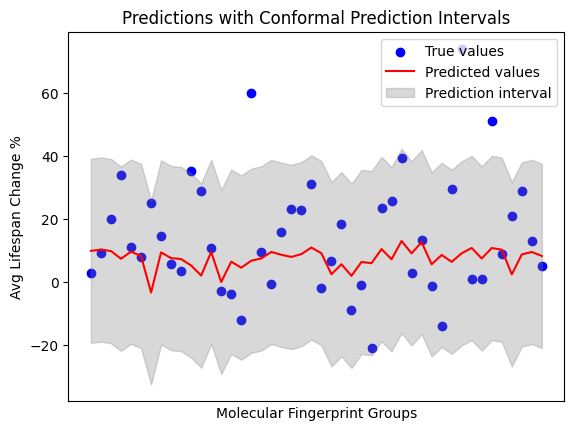

In [19]:
import matplotlib.pyplot as plt

# Scatter plot for actual values
plt.scatter(range(len(y_test)), y_test, color='blue', label='True values')

# Plot predicted values
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted values')

# Plot lower and upper prediction intervals
plt.fill_between(range(len(y_pred)), y_pred_lower, y_pred_upper, color='gray', alpha=0.3, label='Prediction interval')

# Set x-axis labels (custom ticks)
plt.xticks([], [])

# Labels and title
plt.xlabel('Molecular Fingerprint Groups')
plt.ylabel('Avg Lifespan Change %')
plt.title('Predictions with Conformal Prediction Intervals')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [20]:
# Compute the percentage of true values inside the prediction intervals
coverage = np.mean((y_test >= y_pred_lower) & (y_test <= y_pred_upper))
print(f"Prediction interval coverage: {coverage * 100:.2f}%")


Prediction interval coverage: 91.30%


In [21]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")


Mean Absolute Error: 14.22


In [22]:
abstention_percentage = np.mean((y_test < y_pred_lower) | (y_test > y_pred_upper))
print(f"Abstention percentage: {abstention_percentage * 100:.2f}%")


Abstention percentage: 8.70%
